In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import plotly as py
import plotly.graph_objs as go
import os


In [5]:
df = pd.read_csv('C://Users//Prasaadh//Desktop//Data Science//Models//Customer Suggementation using Kmeans//Input//Mall_Customers.csv')
print(df.head(3))
print('----------')
print('Shape: ',df.shape)
print('----------')
print(df.dtypes)
print('----------')
print(df.describe())
print('---------- ')
print(df.isnull().sum())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
----------
Shape:  (200, 5)
----------
CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object
----------
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.

In [6]:
# Some quick feature engineering for plotting

# Age bin / range
bins = [18, 22, 50, 70]
labels = ['Young', 'Adult', 'Senior']
df['Age Range'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)


# Age banding
def age_band(num):
    for i in range(1, 100):
        if num < 10*i :  return f'{(i-1) * 10} ~ {i*10}'

df['age_band'] = df['Age'].apply(age_band)


In [7]:
# For viz: Ratio of Males & Females

x=df.groupby(['Gender'])['Gender'].count()
y=len(df)
r=((x/y)).round(2)

mf_ratio = pd.DataFrame(r).T


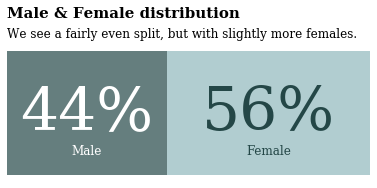

In [8]:
fig, ax = plt.subplots(1,1,figsize=(6.5, 2.5))

ax.barh(mf_ratio.index, mf_ratio['Male'], 
        color='#244747', alpha=0.7, label='Male')
ax.barh(mf_ratio.index, mf_ratio['Female'], left=mf_ratio['Male'], 
        color='#91b8bd', alpha=0.7, label='Female')

ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticks([])

# male percentage
for i in mf_ratio.index:
    ax.annotate(f"{int(mf_ratio['Male'][i]*100)}%", 
                   xy=(mf_ratio['Male'][i]/2, i),
                   va = 'center', ha='center',fontsize=60, fontweight='light', fontfamily='serif',
                   color='white')

    ax.annotate("Male", 
                   xy=(mf_ratio['Male'][i]/2, -0.25),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='white')
    
    
for i in mf_ratio.index:
    ax.annotate(f"{int(mf_ratio['Female'][i]*100)}%", 
                   xy=(mf_ratio['Male'][i]+mf_ratio['Female'][i]/2, i),
                   va = 'center', ha='center',fontsize=60, fontweight='light', fontfamily='serif',
                   color='#244747')
    ax.annotate("Female", 
                   xy=(mf_ratio['Male'][i]+mf_ratio['Female'][i]/2, -0.25),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='#244747')


# Title & Subtitle
fig.text(0.125,1.03,'Male & Female distribution', fontfamily='serif',fontsize=15, fontweight='bold')
fig.text(0.125,0.92,'We see a fairly even split, but with slightly more females.',fontfamily='serif',fontsize=12)  

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    


#ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.06))

# Removing legend due to labelled plot
ax.legend().set_visible(False)
plt.show()

So we have a fairly even split.

Does the split vary by age?

All this information will be important for interpreting our clusters later on.

Always ask then question "so what?" - If we have, for example, more females as customers, how might we advertise differently?

In [10]:
df['Gender 1/0'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

In [11]:
def age_band(num):
    for i in range(1, 100):
        if num < 10*i :  return f'{(i-1) * 10} ~ {i*10}'

df['age_band'] = df['Age'].apply(age_band)


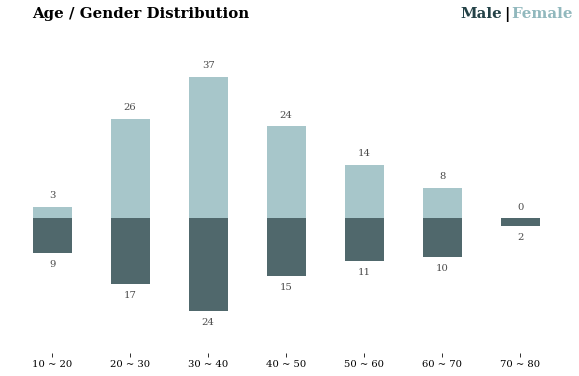

In [12]:
mf = df.groupby('Gender')['age_band'].value_counts().unstack().sort_index().fillna(0).astype(int)


female = mf.loc['Female']
male = -mf.loc['Male']

fig, ax = plt.subplots(1,1, figsize=(10, 6))
ax.bar(male.index, male, width=0.5, color='#244247', alpha=0.8, label='Male')
ax.bar(female.index, female, width=0.5, color='#91b8bd', alpha=0.8, label='Female')
ax.set_ylim(-35, 50)

# Annotations
for i in female.index:
    ax.annotate(f"{female[i]}", 
                   xy=(i, female[i] + 3),
                   va = 'center', ha='center',fontweight='light', fontfamily='serif',
                   color='#4a4a4a')   

for i in male.index:
    ax.annotate(f"{-male[i]}", 
                   xy=(i, male[i] - 3),
                   va = 'center', ha='center',fontweight='light', fontfamily='serif',
                   color='#4a4a4a')
    
for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)

ax.set_xticklabels(mf.columns, fontfamily='serif')
ax.set_yticks([])    

ax.legend().set_visible(False)
fig.text(0.16, 0.9, 'Age / Gender Distribution', fontsize=15, fontweight='bold', fontfamily='serif')

fig.text(0.755,0.9,"Male", fontweight="bold", fontfamily='serif', fontsize=15, color='#244247')
fig.text(0.815,0.9,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.825,0.9,"Female", fontweight="bold", fontfamily='serif', fontsize=15, color='#91b8bd')

plt.show()

AttributeError: 'Text' object has no property 'loc'

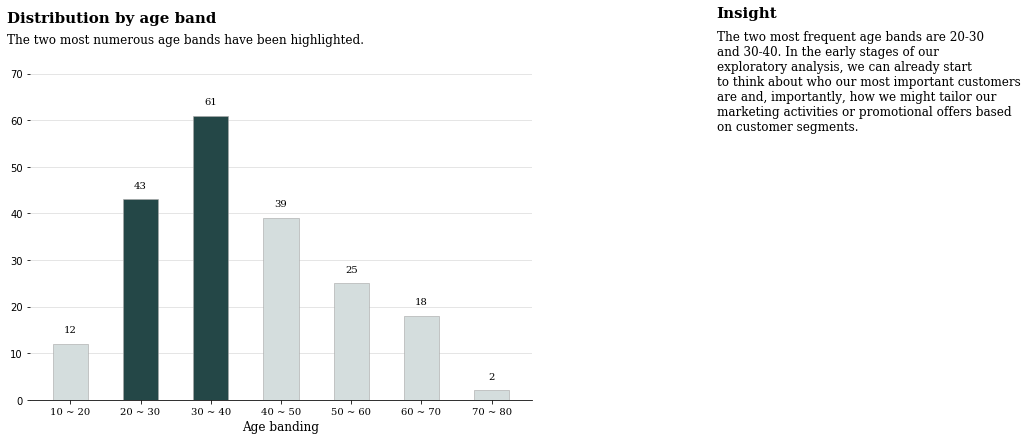

In [13]:
# Order for plotting categorical vars

ab_order = ['10 ~ 20', '20 ~ 30', '30 ~ 40','40 ~ 50','50 ~ 60' ,'60 ~ 70', '70 ~ 80']

data = df['age_band'].value_counts()[ab_order]


color_map = ['#d4dddd' for _ in range(9)]
color_map[2] = color_map[1] = '#244747' 

fig, ax = plt.subplots(1,1, figsize=(9, 6))
ax.bar(data.index, data, width=0.5, 
       edgecolor='darkgray',
       linewidth=0.6,color=color_map)


#annotations
for i in data.index:
    ax.annotate(f"{data[i]}", 
                   xy=(i, data[i] + 3), #i like to change this to roughly 5% of the highest cat
                   va = 'center', ha='center',fontweight='light', fontfamily='serif')

for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
    


ax.set_xticklabels(data.index, fontfamily='serif', rotation=0)

# Title and sub-title

fig.text(0.09, 1, 'Distribution by age band', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.09, 0.95, 'The two most numerous age bands have been highlighted.', fontsize=12, fontweight='light', fontfamily='serif')

fig.text(1.185, 1.01, 'Insight', fontsize=15, fontweight='bold', fontfamily='serif')

fig.text(1.185, 0.715, '''
The two most frequent age bands are 20-30 
and 30-40. In the early stages of our 
exploratory analysis, we can already start
to think about who our most important customers
are and, importantly, how we might tailor our
marketing activities or promotional offers based
on customer segments.
'''
         , fontsize=12, fontweight='light', fontfamily='serif')

ax.grid(axis='y', linestyle='-', alpha=0.4)   

grid_y_ticks = np.arange(0, 75, 10) # y ticks, min, max, then step
ax.set_yticks(grid_y_ticks)
ax.set_axisbelow(True)

#Axis labels

plt.xlabel("Age banding", fontsize=12, fontweight='light', fontfamily='serif',loc='left',y=-1.5)

    
# thicken the bottom line if you want to
plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)

import matplotlib.lines as lines
l1 = lines.Line2D([1.05, 1.05], [0, 1.05], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])



plt.show()

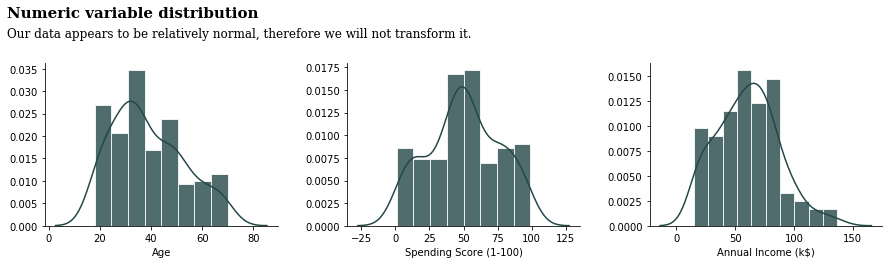

In [14]:
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(1, 3)

fig = plt.figure(figsize=(15, 3))


fig.text(0.09, 1.09, 'Numeric variable distribution', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.09, 1, 'Our data appears to be relatively normal, therefore we will not transform it.', fontsize=12, fontweight='light', fontfamily='serif')


ax1 = fig.add_subplot(gs[0, 0]) # row 0, col 0
ax1 = sns.distplot(df["Age"],color='#244747',hist_kws=dict(edgecolor="white", linewidth=1,alpha=0.8))

ax2 = fig.add_subplot(gs[0, 1]) # row 0, col 1
ax2 = sns.distplot(df["Spending Score (1-100)"],color='#244747',hist_kws=dict(edgecolor="white", linewidth=1,alpha=0.8))

ax3 = fig.add_subplot(gs[0, 2]) # row 1, span all columns
ax3 = sns.distplot(df["Annual Income (k$)"],color='#244747',hist_kws=dict(edgecolor="white", linewidth=1,alpha=0.8))

sns.despine()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None) # useful for adjusting space between subplots


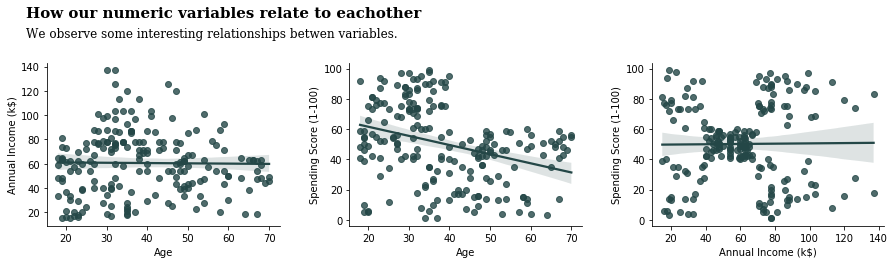

In [15]:
import matplotlib.gridspec as gridspec

# Create 2x2 sub plots
gs = gridspec.GridSpec(1, 3)

fig = plt.figure(figsize=(15, 3))

# Title and sub-title

fig.text(0.105, 1.09, 'How our numeric variables relate to eachother', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.105, 1, 'We observe some interesting relationships betwen variables.', fontsize=12, fontweight='light', fontfamily='serif')

# Grid spec layout

ax1 = fig.add_subplot(gs[0, 0]) # row 0, col 0
ax1 = sns.regplot(x = 'Age' , y = 'Annual Income (k$)' , data = df,color='#244747')

ax2 = fig.add_subplot(gs[0, 1]) # row 0, col 1
ax2 = sns.regplot(x = 'Age' , y = 'Spending Score (1-100)' , data = df,color='#244747')

ax3 = fig.add_subplot(gs[0, 2]) # row 1, span all columns
ax3 = sns.regplot(x = 'Annual Income (k$)' , y = 'Spending Score (1-100)' , data = df,color='#244747')

sns.despine()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None) # useful for adjusting space between subplots

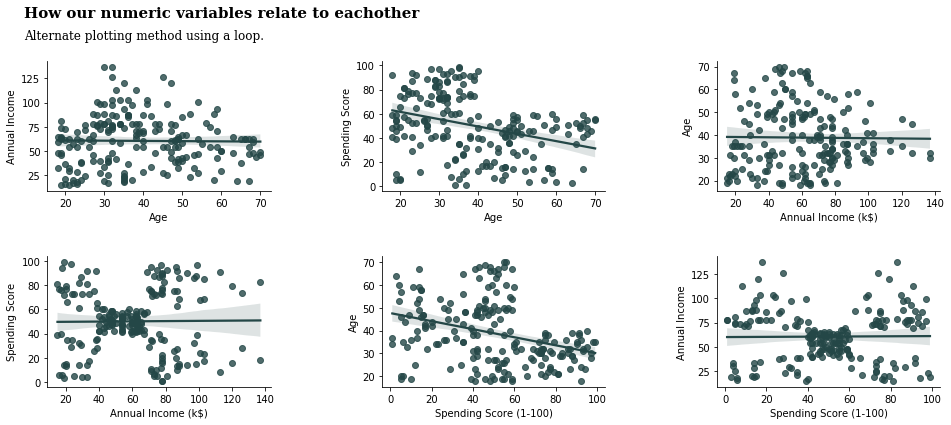

In [16]:
fig = plt.figure(figsize=(16, 6))

# Title and sub-title

fig.text(0.105, .98, 'How our numeric variables relate to eachother', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.105, .93, 'Alternate plotting method using a loop.', fontsize=12, fontweight='light', fontfamily='serif')


n = 0 


for x in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    for y in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
        if x==y: continue

        n += 1
        plt.subplot(2 , 3 , n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        sns.regplot(x = x , y = y , data = df,color='#244747')
        sns.despine()
        plt.ylabel(y.split()[0]+' '+y.split()[1] if len(y.split()) > 1 else y )


plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None) # useful for adjusting space between subplot

plt.show()


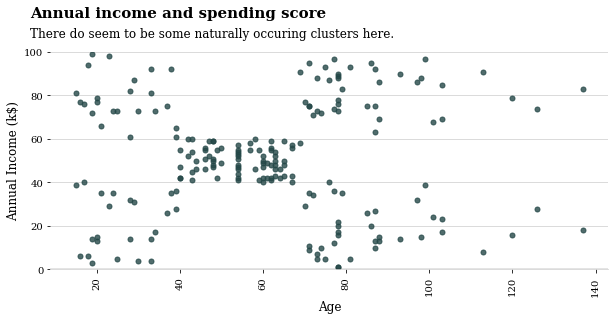

In [17]:

fig, ax = plt.subplots(figsize=(10,4))

# Title & Subtitle
fig.text(0.097,1,'Annual income and spending score', fontfamily='serif',fontsize=15, fontweight='bold')
fig.text(0.097,0.93,'There do seem to be some naturally occuring clusters here.',fontfamily='serif',fontsize=12)

# Ax spines
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)


ax.spines['bottom'].set_color('lightgray')

# Grid
ax.set_axisbelow(True)
ax.yaxis.grid(color='lightgray', linestyle='-')

# Plot

plt.scatter(x = 'Annual Income (k$)' , y = 'Spending Score (1-100)' , data = df ,color='#244747',s = 25 , alpha = 0.8 )


# Tick control
plt.yticks(fontsize=10, fontfamily='serif',fontweight='light')
#ax.yaxis.set_ticks(np.arange(0,140,10))

plt.xticks(fontsize=10, fontfamily='serif',fontweight='light',rotation=90)


# Label control
ax.set_ylabel('Annual Income (k$)',fontfamily='serif',fontsize=12)
ax.set_xlabel('Age',fontfamily='serif',fontsize=12)

ax.set_ylim(0, 100)
plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)

plt.show()